# Dedicated Portfolio using Linear Programming Optimization Techniques
Team Members: John Flume, Ramya Madhuri Desineedi, Scott H Fields, Yue Cui

Submitted on 8th October 2021

In [1]:
## Importing necessary libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import gurobipy as gp
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

In [2]:
## read in data
liabilities = pd.read_csv('liabilities.csv')
bonds = pd.read_csv('bonds.csv')

## Optimal Solution

In [3]:
## set number of variables
## in our case, all bond options are variables
NumVar = len(bonds)
NumVar

13

In [4]:
#Number of years for which we are designing cashflows
n = liabilities.Year.max()
n

8

In [5]:
## set up objective vectors
## the object vectors are the cashflow we need to pay at year=0 for each bond/forward
## define a function to tranform a dataframe of a bond to a list of cashflow
def getobj(bonds):
    obj = []
    ## loop through all bond option
    for i in range(len(bonds)):
        ## when year=0, pay price value for regular bond 
        if bonds['StartTime'][i] == 0:
            obj.append(bonds['Price'][i])
        ## and 0 for forward
        else:
            obj.append(0)
    return obj

obj = getobj(bonds)
obj = np.array(obj)
obj

array([102,   0,  99, 101,  98,  98,   0, 104, 100, 101, 102,  94,   0])

In [6]:
## set up constraint
## in our case, we want to make sure the case flow for each year 
## is greater or equal than the liability of this year

## define a function to tranform a dataframe of a bond to the left hand side od a constraint matrix(A)
def getA(bonds, n):
    ## construct the cash flow from year 1-n for each bond
    Cashflow = []
    for i in range(len(bonds)):
        ## initiate the cash flow from year 1-n to zero
        cf = np.zeros(n)
        ## fill in the cashflow when the bond comes to maturity
        cf[bonds['Maturity'][i] - 1] = 100 + bonds['Coupon'][i]
        ## if is regular bond, set year 1 to before maturity cashflows to coupon value 
        if bonds['StartTime'][i] == 0:
            for j in range(bonds['Maturity'][i] - 1):
                cf[j] = bonds['Coupon'][i]
        else:
            ## if is forward, set cashflow of start year to negative price
            cf[bonds['StartTime'][i]-1] = -1* bonds['Price'][i]
            ## set year 1 to before maturity cashflows to coupon 
            for k in range(bonds['StartTime'][i],bonds['Maturity'][i] - 1):
                cf[k] = bonds['Coupon'][i]
        ##concatenate each year's cash flow
        Cashflow = np.concatenate([Cashflow,cf])

    ## Split the cashflow by each bonds 
    Cashflow_split = np.array_split(Cashflow,len(bonds))

    ## initialize constraint matrix A
    ## # of columns = # of variables
    ## # of rows = # of years
    ## here we transpose the original cashflow matrix since previously, 
    ## each row is a bond, now, each row represents a year
    A = np.array(Cashflow_split).transpose()
    return A

A = getA(bonds,n)
A

array([[ 105. , -100. ,    3.5,    4. ,    2.5,    4. ,    0. ,    9. ,
           6. ,    8. ,    9. ,    7. ,    0. ],
       [   0. ,  103. ,  103.5,  104. ,    2.5,    4. ,  -98. ,    9. ,
           6. ,    8. ,    9. ,    7. ,    0. ],
       [   0. ,    0. ,    0. ,    0. ,  102.5,    4. ,    2. ,    9. ,
           6. ,    8. ,    9. ,    7. ,  -91. ],
       [   0. ,    0. ,    0. ,    0. ,    0. ,  104. ,  102. ,    9. ,
           6. ,    8. ,    9. ,    7. ,    3. ],
       [   0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,  109. ,
         106. ,    8. ,    9. ,    7. ,    3. ],
       [   0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
           0. ,  108. ,    9. ,    7. ,    3. ],
       [   0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
           0. ,    0. ,  109. ,    7. ,    3. ],
       [   0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
           0. ,    0. ,    0. ,  107. ,  103. ]])

In [7]:
## set up constraint on the right hand side (lower limits)
b = np.array(liabilities['Liability'])

## all constraints are greater than or equal constraints
sense = np.array(['>']*len(liabilities))

b

array([1200000, 1800000, 2000000, 2000000, 1600000, 1500000, 1200000,
       1000000])

In [8]:
## define a function to solve the optimal stratgy
## this can only solve minimize optimal
def solveoptimal(NumVar, A, obj, sense, b):
## initialize an empty model
    ojModel = gp.Model()



    ## tell the model how many variables there are
    ojModX = ojModel.addMVar(NumVar)



    ## add the constraints to the model
    ojModCon = ojModel.addMConstrs(A, ojModX, sense, b)
    ojModel.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)



    ojModel.Params.OutputFlag = 0 ## tell gurobi to shut up!!(tensorflow, less talk)
    ojModel.optimize()

    
    x = np.around(ojModX.x, decimals=2)
    y = round(ojModel.objVal,2)
    
    print("year = 0 cashflow: "+str(y))
    print("Number of each bond we buy at year = 0:")
    print(x)
    
    return x, y
    
    

## use the function
x, y = solveoptimal(NumVar, A, obj, sense, b)

Restricted license - for non-production use only - expires 2022-01-13
year = 0 cashflow: 9447500.76
Number of each bond we buy at year = 0:
[ 6522.49     0.   12848.62     0.   15298.32 15680.78     0.   12308.01
     0.   12415.73 10408.99  9345.79     0.  ]


In [9]:
## create b list to store how much money put in each bond at year 0
bondlist = []
for i in range(NumVar):
    total = x[i]*bonds['Price'][i]
    bondlist.append(total)

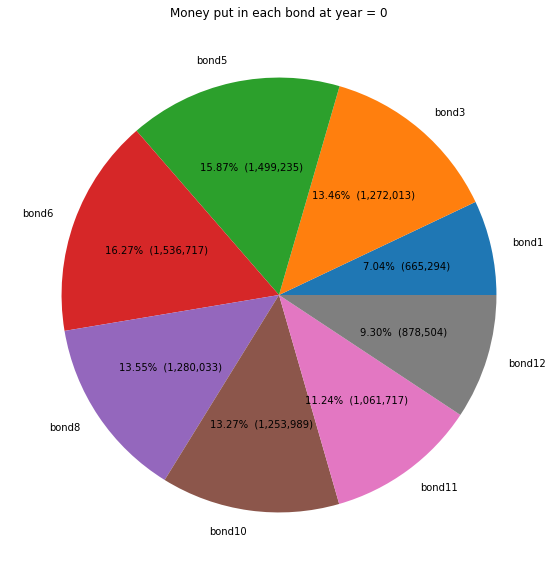

In [10]:
## create par chart to how much money put in each bond at year 0
bond = ['bond1', 'bond2', 'bond3','bond4','bond5','bond6','bond7','bond8','bond9','bond10','bond11','bond12','bond13']
dictionary = dict(zip(bond,bondlist))

names = [key for key,value in dictionary.items() if value!=0]
values = [value for value in dictionary.values() if value!=0]

## creating plot
fig = plt.figure(figsize =(12,10))
plt.title('Money put in each bond at year = 0')
plt.pie(values, labels=names, autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(bondlist)/100))
plt.show()

<AxesSubplot:title={'center':'Cash inflow from bond every year compared to liability'}, ylabel='US Dollar$'>

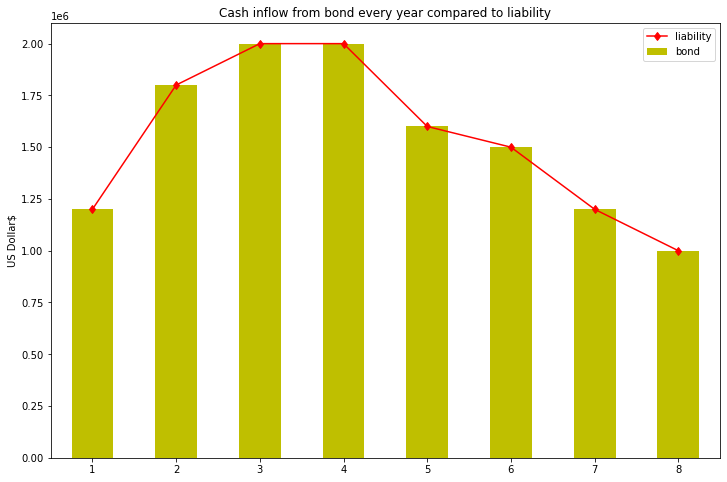

In [11]:
## compute each year's cashflow from bond
CF = A @ x

## create the line chart and bar chart on the same graph
## this graph is used to to check if all years' liability got coverd by bonds' cash inflow
## we can see every year there is a binding constraint
CFcomparison = pd.DataFrame({'liability': b,'bond': CF})
## start from year 1
CFcomparison.index += 1 

## creating the plot
ax = CFcomparison.plot.bar(y='liability', color = 'y', ylabel='US Dollar$', figsize=(12, 8))
plt.title('Cash inflow from bond every year compared to liability')
CFcomparison.plot(y='bond', marker='d', color ="r", ax=ax, use_index=False, mark_right=False)

## Sensitivity Analysis

In [12]:
## since we only cares about the change on liability,
## we just need to focus on b, not c
ojModel = gp.Model()
ojModX = ojModel.addMVar(NumVar)
ojModCon = ojModel.addMConstrs(A, ojModX, sense, b)
ojModel.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)
ojModel.Params.OutputFlag = 0 ## tell gurobi to shut up!!(tensorflow, less talk)
ojModel.optimize()


## find shadow price for each year's constraint
## every constraint seems to be binding
shadowprice = [con.Pi for con in ojModCon]

## lower bound for each year's liability(b) to keep the shadow price equation right
lowerbound = [round(con.SARHSLow,2) for con in ojModCon]

## upper bound for each year's liability(b) to keep the shadow price equation right
upperbound = [round(con.SARHSUp,2) for con in ojModCon]

In [13]:
## show the shadow price for each year's liability
shadow = pd.DataFrame({'liability(b)': b,'shadowprice': shadowprice,'lowerbound':lowerbound,'upperbound':upperbound})
shadow 

,liability(b),shadowprice,lowerbound,upperbound
0,1200000,0.971429,515138.37,inf
1,1800000,0.923671,470168.21,22052336.81
2,2000000,0.909876,431922.42,31062103.33
3,2000000,0.834424,369199.31,20890367.16
4,1600000,0.653628,258427.25,10751333.43
5,1500000,0.617183,159101.43,12618870.11
6,1200000,0.530350,65420.56,11972949.71
7,1000000,0.522580,-0.00,15820500.81


## Real Bonds

In [14]:
## read in bonds data
## access date: 10/6/21
realbond = pd.read_csv('treasuries10.6.csv')
realbond.head()

,MATURITY,COUPON,BID,ASKED,CHG,ASKED YIELD
0,10/15/21,2.875,100.016,100.022,-0.014,0.0154
1,10/31/21,1.250,100.020,100.024,-0.010,0.0994
2,10/31/21,1.500,100.024,100.030,-0.010,0.1191
3,10/31/21,2.000,100.034,100.040,-0.012,0.1590
4,11/15/21,2.000,100.062,100.066,-0.012,0.0590


In [15]:
## define a function to only return month and date of the bond
def monthdate(i):
    i = str(i) 
    return i[:-3]

## define a function to only return year of the bond
def year(i):
    i = str(i)
    return i[-2:]

In [16]:
## create new columns by apply the functions on each value of maturity
realbond['monthdate'] = realbond['MATURITY'].map(monthdate)
realbond['year'] = realbond['MATURITY'].map(year)

## select the data wheich month date equal to 8/15
df = realbond[realbond['monthdate'] == "8/15"]
df.head()

,MATURITY,COUPON,BID,ASKED,CHG,ASKED YIELD,monthdate,year
44,8/15/22,1.500,101.064,101.070,-0.010,0.080,8/15,22
45,8/15/22,1.625,101.100,101.104,-0.006,0.078,8/15,22
46,8/15/22,7.250,106.040,106.044,-0.020,0.094,8/15,22
96,8/15/23,0.125,99.242,99.246,-0.012,0.247,8/15,23
97,8/15/23,2.500,104.052,104.056,-0.014,0.245,8/15,23


In [17]:
## add Price, Coupon, StartTime, Maturity to Df
df['Price'] = df['ASKED']
df['Coupon'] = df['COUPON']
df['StartTime'] = 0

# define a funtion to transform year to year to maturity
def maturity(i):
    maturity = int(i)-21
    return maturity
df['Maturity'] = df['year'].map(maturity)

## select those bond that maturity less or equal than 8 years 
df = df[df['Maturity'] <= 8]

# reset index
df = df.reset_index()

## transform wsj data to the format of previous bond data
realbond_transformed  = df[['Price','Coupon','StartTime','Maturity']]
realbond_transformed

,Price,Coupon,StartTime,Maturity
0,101.070,1.500,0,1
1,101.104,1.625,0,1
2,106.044,7.250,0,1
3,99.246,0.125,0,2
4,104.056,2.500,0,2
5,111.050,6.250,0,2
6,99.204,0.375,0,3
7,105.114,2.375,0,3
8,104.242,2.000,0,4
9,123.126,6.875,0,4


In [18]:
## start solving optimal strategy
## set number of variables
## in our case, all bond options are variables
NumVar = len(realbond_transformed)
NumVar

18

In [19]:
## set up objective vectors
## the object vectors are the cashflow we need to pay at year=0 for each bond/forward
## there is no forwards ao all greater than zero
obj = getobj(realbond_transformed)
obj = np.array(obj)
obj

array([101.07 , 101.104, 106.044,  99.246, 104.056, 111.05 ,  99.204,
       105.114, 104.242, 123.126, 102.186, 127.18 , 106.094, 129.306,
       110.142, 127.25 , 101.266, 135.242])

In [20]:
## set up constraint
## in our case, we want to make sure the case flow for each year 
## is greater or equal than the liability of this year
A = getA(realbond_transformed, n)

## check shape of constraint matrix
## # of columns = # of variables
## # of rows = # of years
A.shape

(8, 18)

In [21]:
## set up constraint on the right hand side (lower limits)
b = np.array(liabilities['Liability'])

## all constraints are greater than or equal constraints
sense = np.array(['>']*len(liabilities))

In [22]:
## find the optmal strategy for real bond
x,y = solveoptimal(NumVar, A, obj, sense, b)

year = 0 cashflow: 11718336.86
Number of each bond we buy at year = 0:
[    0.       0.    6376.46     0.       0.   12838.75     0.   15641.17
     0.   16012.65     0.   13113.52     0.   12998.68     0.   10827.35
     0.    9422.85]


In [23]:
## create b list to store how much money put in each bond at year 0
bondlist = []
for i in range(NumVar):
    total = x[i]*realbond_transformed['Price'][i]
    bondlist.append(total)

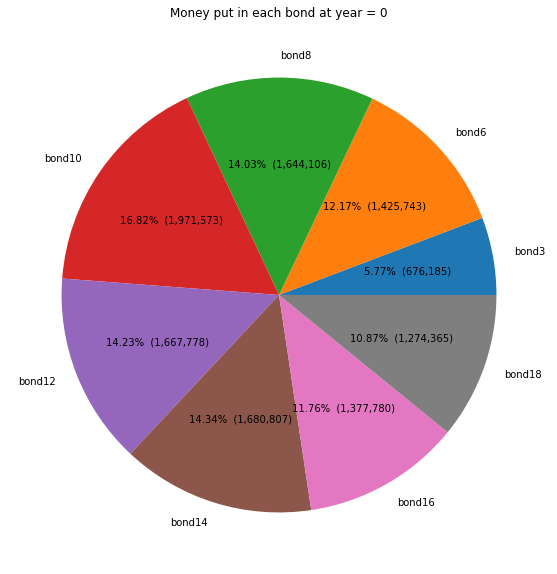

In [24]:
## create par chart to how much money put in each bond at year 0
bond = ['bond1', 'bond2', 'bond3','bond4','bond5','bond6','bond7','bond8','bond9','bond10','bond11','bond12','bond13','bond14','bond15','bond16','bond17','bond18']
dictionary = dict(zip(bond,bondlist))

names = [key for key,value in dictionary.items() if value!=0]
values = [value for value in dictionary.values() if value!=0]

## creating plot
fig = plt.figure(figsize =(12,10))
plt.title('Money put in each bond at year = 0')
plt.pie(values, labels=names, autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(bondlist)/100))
plt.show()

<AxesSubplot:title={'center':'Cash inflow from bond every year compared to liability'}, ylabel='US Dollar$'>

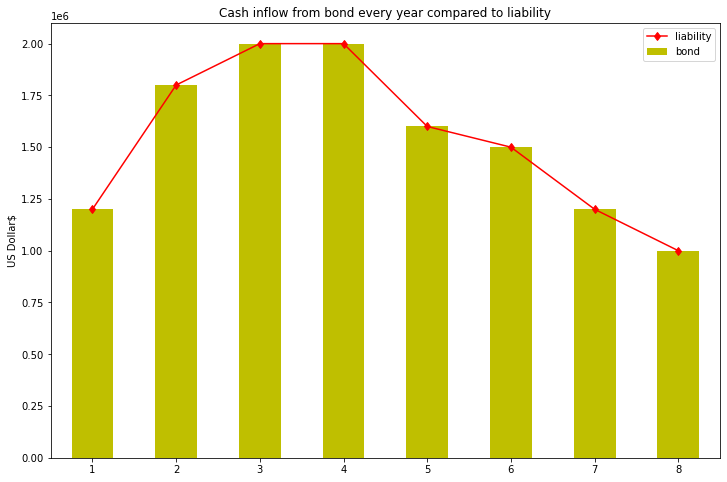

In [25]:
## compute each year's cashflow from bond
CF = A @ x

## create the line chart and bar chart on the same graph
## this graph is used to to check if all years' liability got coverd by bonds' cash inflow
## we can see every year there is a binding constraint
CFcomparison = pd.DataFrame({'liability': b,'bond': CF})
## start from year 1
CFcomparison.index += 1 

## creating the plot
ax = CFcomparison.plot.bar(y='liability', color = 'y', ylabel='US Dollar$', figsize=(12, 8))
plt.title('Cash inflow from bond every year compared to liability')
CFcomparison.plot(y='bond', marker='d', color ="r", ax=ax, use_index=False, mark_right=False)